In [1]:
import os
import os.path
import pickle

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

In [2]:
NOTE = '全特徴量を使用したXGBoost.016とは異なりカテゴリ変数にダミーエンコーディングを行わない。'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '021'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1
CATEGORICAL_FEATURES =  [
        'batterID', 'pitcherID', 'Match',
        'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher',
        'isBottom', 'batterTeam', 'pitcherTeam'
    ]

021_submission.csv 021


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  features=None) -> Pipeline:
    clf = XGBClassifier(n_estimators=200, learning_rate=0.01, n_jobs=-1)
    clf.feature_names_ = features
    return Pipeline(steps=[
        ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

In [6]:
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam']

In [7]:
features = [c for c in train.columns if c not in ('id', 'y')]
assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
discrete_features = [f for f in features if f not in categorical_features]
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'b1',
 'b2',
 'b3',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabe

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator()
    clf.fit(X_train, y_train.values)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:33:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 1)**********
[[4469  447  130   20    0    0    0    0]
 [1621 1988   94   43    0    0    0    0]
 [1342  381  627   42    0    1    0    0]
 [ 581  125  118  885    0    0    0    0]
 [ 251   60   52   77  100    0    0    0]
 [  74   18   14   33    1   10    0    0]
 [   2    2    1    3    0    0    0    0]
 [  32   13    4   25    0    0    0   22]]

**********Confusion matrix for validation set (Fold 1)**********
[[939 232  79  14   2   0   0   1]
 [579 280  61  15   1   0   0   0]
 [391 100  91  16   0   0   0   1]
 [211  52  39 125   0   0   0   0]
 [ 76  16  11  31   1   0   0   0]
 [ 20   7   1   9   0   0   0   0]
 [  1   0   1   1   0   0   0   0]
 [  5   5   6   8   0   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:35:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 2)**********
[[4493  418  144   11    0    0    0    0]
 [1577 2030  103   36    0    0    0    0]
 [1318  365  681   27    1    1    0    0]
 [ 529  119  132  929    0    0    0    0]
 [ 260   58   51   85   86    0    0    0]
 [  68   19   12   33    0   18    0    0]
 [   3    3    1    2    0    0    0    0]
 [  34   15   11   25    0    0    0   11]]

**********Confusion matrix for validation set (Fold 2)**********
[[979 190  84  11   2   0   0   1]
 [565 320  33  13   2   1   0   2]
 [381 115  85  17   1   0   0   0]
 [186  49  56 136   0   0   0   0]
 [ 58  19  20  37   1   0   0   0]
 [ 18   3   5  11   0   0   0   0]
 [  0   1   0   1   0   0   0   0]
 [ 11   5   1   7   0   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:37:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 3)**********
[[4517  404  124   21    0    0    0    0]
 [1621 1988  106   31    0    0    0    0]
 [1339  387  631   36    0    1    0    0]
 [ 552  134  147  875    0    0    0    0]
 [ 269   58   60   79   74    0    0    0]
 [  72   20   11   32    0   15    0    0]
 [   4    2    1    2    0    0    0    0]
 [  34   15    8   25    0    0    0   14]]

**********Confusion matrix for validation set (Fold 3)**********
[[980 218  57   9   1   2   0   0]
 [582 301  35  16   1   1   0   0]
 [373 117  85  23   0   0   0   0]
 [200  50  43 135   0   0   0   0]
 [ 67  19  14  34   1   0   0   0]
 [ 16   6   3  12   0   0   0   0]
 [  0   1   0   1   0   0   0   0]
 [  8   5   2   8   1   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 4)**********
[[4530  404  116   16    1    0    0    0]
 [1578 2029  104   34    0    0    0    0]
 [1358  377  627   30    1    1    0    0]
 [ 571  122  146  870    0    0    0    0]
 [ 258   61   57   88   76    0    0    0]
 [  68   17   11   31    0   22    0    0]
 [   2    1    2    4    0    0    0    0]
 [  36   14   13   22    0    0    0   11]]

**********Confusion matrix for validation set (Fold 4)**********
[[964 203  80  14   2   1   0   2]
 [560 309  50  18   0   0   0   0]
 [382 116  86  13   0   1   0   0]
 [206  41  56 123   1   0   0   0]
 [ 70  17  14  33   1   0   0   0]
 [ 20   4   4   8   1   1   0   0]
 [  1   1   0   0   0   0   0   0]
 [  8   3   2  11   0   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:41:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 5)**********
[[4551  364  137   15    0    0    0    0]
 [1610 2008   93   33    1    0    0    0]
 [1346  376  639   33    0    0    0    0]
 [ 569  121  116  903    0    0    0    0]
 [ 257   64   53   91   75    0    0    0]
 [  76   18    9   30    2   14    0    0]
 [   4    1    2    2    0    0    0    0]
 [  39   16    6   20    0    0    0   15]]

**********Confusion matrix for validation set (Fold 5)**********
[[947 225  74  19   1   0   0   0]
 [574 312  35  16   0   0   0   0]
 [381  94  92  29   0   2   0   0]
 [205  64  42 113   3   0   0   0]
 [ 69  18  12  36   0   0   0   0]
 [ 22   5   2   9   0   0   0   0]
 [  1   0   0   1   0   0   0   0]
 [ 13   3   1   7   0   0   0  

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.372445,0.191531
std,0.006081,0.005633
min,0.365114,0.184983
25%,0.370177,0.186073
50%,0.370455,0.193526
75%,0.375248,0.196244
max,0.381232,0.196829


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,1,0,1
2,2,0,0,0,1
3,3,2,2,0,1
4,4,4,2,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,1,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.154919,0.233859,0.293460,0.088310,0.069212,0.058513,0.048945,0.052783,27446,1
1,0.326523,0.177947,0.251501,0.060322,0.056575,0.043947,0.040023,0.043161,113,1
2,0.373836,0.323564,0.121974,0.035433,0.035763,0.037828,0.034450,0.037151,4479,1
3,0.382317,0.308217,0.124742,0.036237,0.036575,0.038686,0.035232,0.037994,29080,1
4,0.420811,0.172896,0.192955,0.043725,0.047206,0.042064,0.038308,0.042035,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.169416,0.126248,0.204102,0.233606,0.111664,0.101817,0.026469,0.026678,24272,5
33804,0.250288,0.117308,0.137014,0.172585,0.133492,0.127587,0.030741,0.030984,29106,5
33805,0.241044,0.121592,0.131762,0.178888,0.130489,0.132246,0.031864,0.032115,20679,5
33806,0.201327,0.131522,0.145626,0.197968,0.137963,0.121942,0.031701,0.031951,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,1.127564,1.869650,0.789385,0.288882,0.253000,0.237191,0.215756,0.218572
1,1,1.902873,1.571059,0.567398,0.186418,0.192407,0.199400,0.181455,0.198989
2,2,0.681477,0.851440,1.683617,0.734505,0.329475,0.250863,0.216375,0.252248
3,3,0.932034,0.930308,0.951346,0.745922,0.667223,0.445905,0.160481,0.166781
4,4,1.667977,1.713807,0.614432,0.233804,0.210405,0.192933,0.175489,0.191153
...,...,...,...,...,...,...,...,...,...
33803,33803,2.138884,0.882371,0.900445,0.230556,0.232639,0.217290,0.197605,0.200209
33804,33804,0.944855,0.867749,0.844505,0.673174,0.701057,0.511394,0.147402,0.309863
33805,33805,0.989337,0.822869,0.858054,0.691153,0.586585,0.515312,0.150380,0.386311
33806,33806,0.669326,0.991521,1.321667,0.998008,0.352710,0.248315,0.207849,0.210603


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,0
2,2,2
3,3,2
4,4,1
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,2


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.444540
1    0.256123
2    0.159933
3    0.138991
5    0.000414
Name: y, dtype: float64

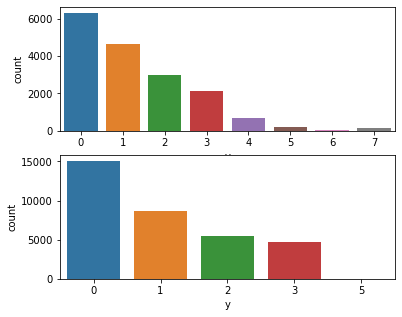

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.3724450040309629, 0.19153095269799608)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"021_submission.csv","Stratified-Kfold(K=5)","0.372445","0.191531","","全特徴量を使用したXGBoost.016とは異なりカテゴリ変数にダミーエンコーディングを行わない。"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 1.4 s


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        else:
            feature_names = final_estimator.feature_names_
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 7.25 s
